In [4]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from collections import defaultdict
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time

class global_1:
    def __init__(self, k=6, nearest=5, maxiter=1000, temp=10, cool_rate=0.8, beta_scale=0.5, reg=0.005):
        self.k = k
        self.beta_scale = beta_scale
        self.reg = reg
        self.nearest = nearest
        self.maxiter = maxiter
        self.temp = temp
        self.cool_rate = cool_rate

        self.n = None
        self.d = None
        self.X = None
        self.y = None
        self.distances_matrix = None
        self.adj_matrix = None
        self.metric = None
        self.total_graph_distance = []

    def greedy_approach(self):
        node_values = np.sum(self.distances_matrix, axis=0)
        d_copy = self.distances_matrix.copy()
        np.fill_diagonal(d_copy, np.inf)
        visited = np.zeros(self.n)

        matrix = np.zeros((self.n, self.n))
        for iteration in range(self.k):
            current_vals = node_values.copy()
            node_mask = (visited <= iteration)

            while np.sum(visited) < (iteration + 1) * self.n:
                i = np.argmax(current_vals * node_mask)
                j = np.argmin(d_copy[:, i] / node_mask)

                visited[i] += 1
                visited[j] += 1
                node_mask[i], node_mask[j] = False, False
                matrix[i, j], matrix[j, i] = 1, 1

                node_values[i] -= self.distances_matrix[i, j]
                node_values[j] -= self.distances_matrix[i, j]
                d_copy[i, j], d_copy[j, i] = np.inf, np.inf

        self.adj_matrix = matrix
        self.total_graph_distance = []
        return matrix

    def find_near_solution(self, previous_solution):
        near_matrix = previous_solution.copy()
        j1 = np.random.choice(self.n)
        i_one_j1 = np.random.choice(np.where(near_matrix[:, j1] == 1)[0])
        zero_candidates = np.where(near_matrix[:, j1] == 0)[0]
        zero_candidates = zero_candidates[zero_candidates != j1]

        if zero_candidates.size == 0:
            return near_matrix

        close_nots = np.argpartition(self.distances_matrix[zero_candidates, j1], self.nearest)[:self.nearest]
        i_not_j1 = np.random.choice(zero_candidates[close_nots])

        fails = 0
        while True:
            j2 = np.random.choice(np.where(near_matrix[i_not_j1] == 1)[0])
            fails += 1

            if fails % 100 == 0:
                return near_matrix

            if (near_matrix[i_one_j1, j2]) == 0 and (j2 != j1) and (i_one_j1 != j2):
                break

        near_matrix[i_one_j1, j1] = 0
        near_matrix[j1, i_one_j1] = 0
        near_matrix[i_not_j1, j1] = 1
        near_matrix[j1, i_not_j1] = 1
        near_matrix[i_not_j1, j2] = 0
        near_matrix[j2, i_not_j1] = 0
        near_matrix[i_one_j1, j2] = 1
        near_matrix[j2, i_one_j1] = 1

        return near_matrix

    def annealing(self):
        if self.adj_matrix is None:
            raise ValueError("Please run the greedy approach first")

        current = self.adj_matrix.copy()
        loss_current = np.sum((self.distances_matrix**1) * current)
        self.total_graph_distance.append(loss_current)

        for i in range(self.maxiter):
            T = max(self.temp * self.cool_rate**i, 10e-20) + 1 / (i + 1)
            candidate = self.find_near_solution(current.copy())
            loss_candidate = np.sum((self.distances_matrix**1) * candidate)
            if loss_candidate < loss_current:
                current = candidate
                loss_current = loss_candidate
            else:
                prob = np.exp(np.max([-(loss_candidate - loss_current) / T, -50]))
                if np.random.rand() < prob:
                    current = candidate
                    loss_current = loss_candidate

            self.total_graph_distance.append(loss_current)

        self.adj_matrix = current
        return current

    def get_distance_matrix(self, data, metric):
        self.distances_matrix = np.apply_along_axis(metric, 2, data[:, np.newaxis, :] - data[np.newaxis, :, :])

    def fit(self, X, y, fit_metric=False, show_loss=False):
        if fit_metric:
            self.get_metric(X, y)
        else:
            self.metric = np.linalg.norm

        self.n = X.shape[0]
        self.d = X.shape[1]
        self.X = X
        self.y = y
        self.get_distance_matrix(X, self.metric)

        start_time = time.time()
        self.greedy_approach()
        greedy_matrix = self.adj_matrix.copy()
        self.annealing()
        print(f"Fitting took {time.time() - start_time:.2f} seconds")

        if show_loss:
            self.show_total_distance(greedy_matrix, self.adj_matrix)

        return self

    def get_metric(self, X, y):
        self.metric = np.linalg.norm
        pass

    def label_from_stationary(self, stationary, show_probabilities=False):
        if not np.isclose(np.sum(stationary), 1):
            raise ValueError("The weights do not sum to 1.")
        
        class_weight_sums = defaultdict(float)
        for weight, label in zip(stationary, self.y):
            class_weight_sums[label] += weight

        class_probabilities = dict(class_weight_sums)
        if show_probabilities:
            return class_probabilities
        
        return max(class_probabilities, key=class_probabilities.get)

    def predict(self, points, beta_scale=None, reg=None):
        if len(points.shape) == 1:
            points = points[np.newaxis, :]
        predictions = []

        if beta_scale is not None:
            self.beta_scale = beta_scale
        if reg is not None:
            self.reg = reg

        dist_array = np.apply_along_axis(self.metric, 2, self.X[:, np.newaxis, :] - points[np.newaxis, :, :])
        std = np.std(dist_array)

        # Vectorize the edge weight calculations
        edge_weights = np.exp(-dist_array**2 / (self.beta_scale * std**2))

        # Vectorize transition matrix creation and normalization
        transition_matrices = self.adj_matrix[:, :, np.newaxis] * edge_weights
        row_sums = np.sum(transition_matrices, axis=0, keepdims=True)
        epsilon = 1e-10
        row_sums[row_sums == 0] = epsilon
        transition_matrices = (transition_matrices / row_sums) + self.reg / self.n
        transition_matrices /= np.sum(transition_matrices, axis=0, keepdims=True)

        # Calculate stationary distributions using eigen decomposition
        for i in range(transition_matrices.shape[2]):
            transition = transition_matrices[:, :, i]
            eigenvalues, eigenvectors = np.linalg.eig(transition.T)
            stationary = np.real(eigenvectors[:, np.argmax(np.real(eigenvalues))])
            stationary /= np.sum(stationary)
            predictions.append(self.label_from_stationary(stationary))

        return predictions

    def show_total_distance(self, start_matrix=None, end_matrix=None):
        plt.title("Loss over iterations")
        plt.xlabel("Iteration")
        plt.ylabel("Total Graph Distance")
        plt.plot(self.total_graph_distance)
        plt.show()

        if start_matrix is not None and end_matrix is not None:
            greedy_distance = np.sum(start_matrix * self.distances_matrix)
            annealed_distance = np.sum(end_matrix * self.distances_matrix)
            print("Greedy Solution:", greedy_distance)
            print("Annealed Solution:", annealed_distance)
            print("Percent Decrease: {:.2f}%".format(100 * (greedy_distance - annealed_distance) / greedy_distance))

# Example usage
# Note: Replace X and y with actual MNIST data arrays.
# from sklearn.datasets import load_digits
# digits = load_digits()
# X = digits.data
# y = digits.target

# model = global_1()
# model.fit(X, y)
# predictions = model.predict(X_test)  # X_test should be the test data
# print("Predictions:", predictions)


In [6]:
# Load in the small mnist data
data = load_digits()
X = data.data
y = data.target

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# Parameters
k = 6
num_nearest = 5
maxiter = 10000
temp = 100
alpha = 0.85
beta_scale = 0.5
reg = 0.005


/var/folders/t4/43zvz_r119l5fk_hdwn6_mbw0000gn/T/ipykernel_93975/765543096.py:38: RuntimeWarning: divide by zero encountered in divide
  j = np.argmin(d_copy[:, i] / node_mask)


Fitting took 55.30 seconds


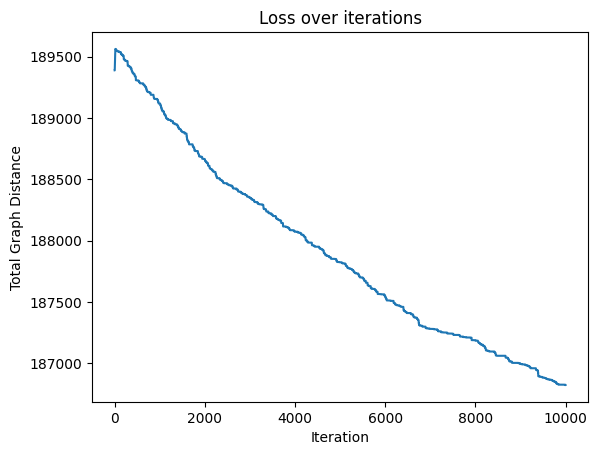

Greedy Solution: 189387.92820193787
Annealed Solution: 186823.7303489394
Percent Decrease: 1.35%


In [8]:
model_g1 = global_1(k=k, nearest=num_nearest, maxiter=maxiter, temp=temp, cool_rate=alpha, beta_scale=beta_scale, reg=reg)
model_g1.fit(X_train, y_train, show_loss=True)

In [9]:
# Predict the test data
predictions = model_g1.predict(X_test)
accuracy = np.mean(predictions == y_test)
print("Accuracy: {}".format(accuracy))

KeyboardInterrupt: 